# Exercise 10: Convolutional neural network

In this exercise, we will look at an introduction of classifying images using deep convolutional neural networks.

Training convolutional networks on many images can be quite time consuming. We use the same small standard dataset from last weeks exercise. I tgives a good introduction to the topic and is available in Keras. 

The CIFAR-10 data set consists of 50000 training and 10000 test images of size 32x32 labelled into 10 classes. See also https://keras.io/datasets/#cifar10-small-image-classification


In [0]:
%matplotlib inline

import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.datasets import cifar10
import matplotlib.pyplot as plt

Get the datasets if you did not load them last week. Some people experienced problems with loading directly from keras, if that did not work, you can also use the function below which uses http instead of https.

In [0]:
# the keras routines below might generate a ssl error inside jupyter notebooks
#
# (x_train, y_train_label), (x_test, y_test_label) = cifar10.load_data()
# 

# this is the same code, but using http instead of https
from tensorflow.python.keras.datasets.cifar import load_batch

def load_cifar_data():
    """Loads CIFAR10 dataset.
    # Returns
        Tuple of Numpy arrays: `(x_train, y_train), (x_test, y_test)`.
    """
    dirname = 'cifar-10-batches-py'
    origin = 'http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'
    path = keras.utils.get_file(dirname, origin=origin, untar=True)

    num_train_samples = 50000

    x_train = np.empty((num_train_samples, 3, 32, 32), dtype='uint8')
    y_train = np.empty((num_train_samples,), dtype='uint8')

    for i in range(1, 6):
        fpath = os.path.join(path, 'data_batch_' + str(i))
        (x_train[(i - 1) * 10000: i * 10000, :, :, :],
         y_train[(i - 1) * 10000: i * 10000]) = load_batch(fpath)

    fpath = os.path.join(path, 'test_batch')
    x_test, y_test = load_batch(fpath)

    y_train = np.reshape(y_train, (len(y_train), 1))
    y_test = np.reshape(y_test, (len(y_test), 1))

    if K.image_data_format() == 'channels_last':
        x_train = x_train.transpose(0, 2, 3, 1)
        x_test = x_test.transpose(0, 2, 3, 1)

    return (x_train, y_train), (x_test, y_test)

In [3]:
(x_image_train, y_train_label), (x_image_test, y_test_label) = cifar10.load_data()
print(x_image_train.shape)
print(y_train_label.shape)

170500096/170498071 [==============================] - 6s 0us/step
(50000, 32, 32, 3)
(50000, 1)


Let us look at some of the training images. The images contain 10 different classes.

In [0]:
label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
def show_images(images, labels):
    fig, axes = plt.subplots(3, 5)
    fig.subplots_adjust(hspace=0.6, wspace=0.3)
    
    for i, ax in enumerate(axes.flat):
        # Plot image.
        example = np.random.randint(len(images))
        ax.imshow(images[example])
        
        # Name of the true class.
        cls_true_name = label_names[labels[example, 0]]
        xlabel = "{0}".format(cls_true_name)
        
        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    return

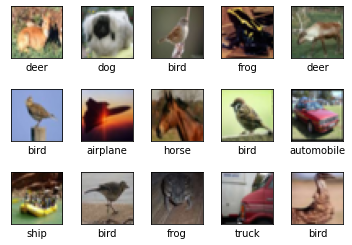

In [5]:
show_images(x_image_train, y_train_label)

In order to compute the loss function (cross entropy) the label data set must be one-hot encoded (also called categorical data)

In [0]:
num_classes = 10
y_train = keras.utils.to_categorical(y_train_label)
y_test = keras.utils.to_categorical(y_test_label)

### Preprocessing

Any input to a neural network should be normalized. For images this could be done per image (which would also normalize contrast) or just adjust the range globally. Normalization should either be so that the data is between 0 and 1 or (even better) between -1 and 1.

In [7]:
x_train = (2.0 * x_image_train.astype(np.float32) / 255.0) - 1.0
x_test = (2.0 * x_image_test.astype(np.float32) / 255.0) - 1.0
print(np.min(x_train), np.max(x_train))

-1.0 1.0


The following code calculates a simple convolutional network. 

For image classification, we want to have some convolutional layers, some padding and probably at the end some dense (fully connected) layers.

The last layer needs softmax as activation function for the correct number of classes.

In [0]:
def build_model_1():
    model = keras.Sequential()
    
    # add input shape
    model.add(keras.layers.Layer(input_shape=(32, 32, 3)))
    
    # add convolutional and pooling layers first
    model.add(keras.layers.Conv2D(32,3, padding='valid', activation='relu'))
    # add a pooling layer and another  convolutional layer here
    model.add(keras.layers.Conv2D(32,3, padding='valid', activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2)))
    model.add(keras.layers.Conv2D(32,3, padding='valid', activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2)))
    
    
    # add dense layers (need to flatten the input first)
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(128, activation='relu'))
  
    # add the last layer for the number of classes and using softmax
    model.add(keras.layers.Dense(10, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy',
                  optimizer='sgd',
                  metrics=['accuracy'])
    return model
    

In [0]:
model = build_model_1()

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer (Layer)                (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1152)              0

In [11]:
history = model.fit(x_train, y_train, epochs=2, batch_size=128, validation_data=(x_test, y_test))

Epoch 1/2
391/391 [==============================] - 3s 7ms/step - loss: 2.1237 - accuracy: 0.2382 - val_loss: 1.8982 - val_accuracy: 0.3270
Epoch 2/2
391/391 [==============================] - 2s 6ms/step - loss: 1.8047 - accuracy: 0.3606 - val_loss: 1.7319 - val_accuracy: 0.3788


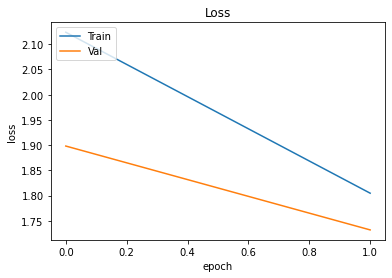

In [12]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Train', 'Val'], loc='upper left')

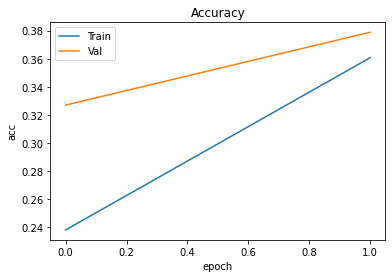

In [13]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.legend(['Train', 'Val'], loc='upper left')

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer (Layer)                (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1152)              0

In [15]:
model_train_100 = model.fit(x_train, y_train, epochs=100, batch_size=128, validation_data=(x_test, y_test))

Epoch 1/100
391/391 [==============================] - 2s 6ms/step - loss: 1.6553 - accuracy: 0.4130 - val_loss: 1.6281 - val_accuracy: 0.4153
Epoch 2/100
391/391 [==============================] - 2s 6ms/step - loss: 1.5481 - accuracy: 0.4505 - val_loss: 1.4891 - val_accuracy: 0.4641
Epoch 3/100
391/391 [==============================] - 2s 6ms/step - loss: 1.4649 - accuracy: 0.4779 - val_loss: 1.4590 - val_accuracy: 0.4790
Epoch 4/100
391/391 [==============================] - 2s 6ms/step - loss: 1.4005 - accuracy: 0.5025 - val_loss: 1.3745 - val_accuracy: 0.5019
Epoch 5/100
391/391 [==============================] - 2s 6ms/step - loss: 1.3505 - accuracy: 0.5211 - val_loss: 1.3288 - val_accuracy: 0.5289
Epoch 6/100
391/391 [==============================] - 2s 6ms/step - loss: 1.3066 - accuracy: 0.5381 - val_loss: 1.3270 - val_accuracy: 0.5231
Epoch 7/100
391/391 [==============================] - 2s 6ms/step - loss: 1.2734 - accuracy: 0.5504 - val_loss: 1.2785 - val_accuracy: 0.5459

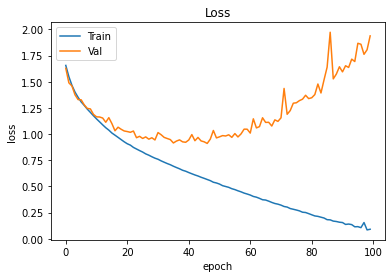

In [16]:
import matplotlib.pyplot as plt
plt.plot(model_train_100.history['loss'])
plt.plot(model_train_100.history['val_loss'])
plt.title('Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Train', 'Val'], loc='upper left')

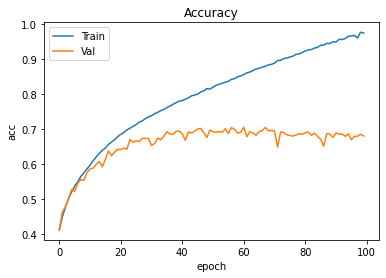

In [17]:
plt.plot(model_train_100.history['accuracy'])
plt.plot(model_train_100.history['val_accuracy'])
plt.title('Accuracy')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.legend(['Train', 'Val'], loc='upper left')

### Going further with the model

Even a very simple network gets some decent results. From here we can go further using deeper networks and additional features.

Try the following:
- Train for more episodes
- Make the network deeper by adding more layers
- Increase the capacity by adding more nodes per layer
- add regularization
- add dropout

Convolutional networks benefit from using GPU resources. Google provides a jupyter notebook environment with GPU support: https://colab.research.google.com

This jupyter notebook should run as it is in that environment. To actually get a GPU you have to change the runtime type in the menu 'Runtime'

When building new models, I usually like to keep the old ones for comparison, so I would recommend defining a new function for the new model.

In [0]:
def build_model_2():
    model = keras.Sequential()
    
    # add input shape
    model.add(keras.layers.Layer(input_shape=(32, 32, 3)))
    
    # add convolutional and pooling layers first
    model.add(keras.layers.Conv2D(32,3, padding='valid', activation='relu'))

    # add a pooling layer and another  convolutional layer here
    model.add(keras.layers.Conv2D(32,3, padding='valid', activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2)))
    model.add(keras.layers.Conv2D(32,3, padding='valid', activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2)))

    model.add(keras.layers.Dropout(0.2))
    
    model.add(keras.layers.Conv2D(32,3, padding='valid', activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2)))

    model.add(keras.layers.Dropout(0.2))
    
    # add dense layers (need to flatten the input first)
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(128, activation='relu'))
  
    # add the last layer for the number of classes and using softmax
    model.add(keras.layers.Dense(10, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy',
                  optimizer='sgd',
                  metrics=['accuracy'])
    return model

In [0]:
model2 = build_model_2()

In [28]:
model2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_3 (Layer)              (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 12, 12, 32)        9248      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 6, 6, 32)         

In [29]:
history2 = model2.fit(x_train, y_train, epochs=2, batch_size=128, validation_data=(x_test, y_test))

Epoch 1/2
391/391 [==============================] - 3s 7ms/step - loss: 2.2834 - accuracy: 0.1433 - val_loss: 2.2259 - val_accuracy: 0.2054
Epoch 2/2
391/391 [==============================] - 3s 7ms/step - loss: 2.1080 - accuracy: 0.2173 - val_loss: 1.9641 - val_accuracy: 0.2949


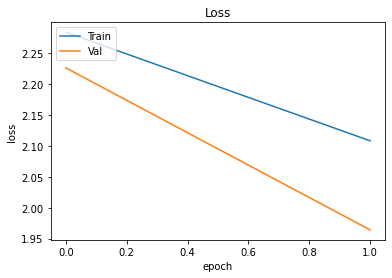

In [30]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Train', 'Val'], loc='upper left')

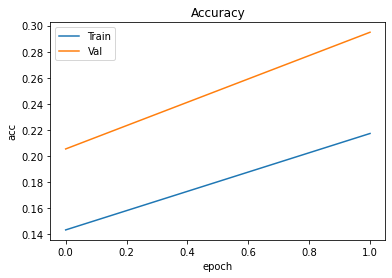

In [31]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Accuracy')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.legend(['Train', 'Val'], loc='upper left')

In [32]:
history2_100 = model2.fit(x_train, y_train, epochs=100, batch_size=128, validation_data=(x_test, y_test))

Epoch 1/100
391/391 [==============================] - 3s 6ms/step - loss: 1.9350 - accuracy: 0.2787 - val_loss: 1.8163 - val_accuracy: 0.3382
Epoch 2/100
391/391 [==============================] - 3s 6ms/step - loss: 1.8173 - accuracy: 0.3223 - val_loss: 1.7172 - val_accuracy: 0.3726
Epoch 3/100
391/391 [==============================] - 3s 6ms/step - loss: 1.7356 - accuracy: 0.3490 - val_loss: 1.6332 - val_accuracy: 0.3966
Epoch 4/100
391/391 [==============================] - 2s 6ms/step - loss: 1.6771 - accuracy: 0.3726 - val_loss: 1.6343 - val_accuracy: 0.4052
Epoch 5/100
391/391 [==============================] - 3s 6ms/step - loss: 1.6303 - accuracy: 0.3938 - val_loss: 1.5522 - val_accuracy: 0.4355
Epoch 6/100
391/391 [==============================] - 2s 6ms/step - loss: 1.5952 - accuracy: 0.4077 - val_loss: 1.5399 - val_accuracy: 0.4461
Epoch 7/100
391/391 [==============================] - 3s 6ms/step - loss: 1.5576 - accuracy: 0.4261 - val_loss: 1.4804 - val_accuracy: 0.4635

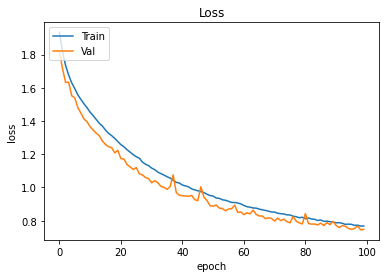

In [33]:
plt.plot(history2_100.history['loss'])
plt.plot(history2_100.history['val_loss'])
plt.title('Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Train', 'Val'], loc='upper left')

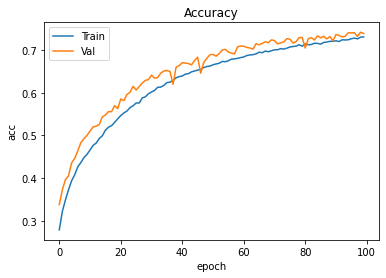

In [34]:
plt.plot(history2_100.history['accuracy'])
plt.plot(history2_100.history['val_accuracy'])
plt.title('Accuracy')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.legend(['Train', 'Val'], loc='upper left')

In [0]:
def build_model_3():
    model = keras.Sequential()
    
    # add input shape
    model.add(keras.layers.Layer(input_shape=(32, 32, 3)))
    
    # add convolutional and pooling layers first
    model.add(keras.layers.Conv2D(64,3, padding='valid', activation='relu'))

    # add a pooling layer and another  convolutional layer here
    model.add(keras.layers.Conv2D(64,3, padding='valid', activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2)))
    model.add(keras.layers.Conv2D(32,3, padding='valid', activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2)))

    model.add(keras.layers.Dropout(0.2))
    
    model.add(keras.layers.Conv2D(32,3, padding='valid', activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2)))

    model.add(keras.layers.Dropout(0.2))
    
    # add dense layers (need to flatten the input first)
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(128, activation='relu'))
  
    # add the last layer for the number of classes and using softmax
    model.add(keras.layers.Dense(10, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy',
                  optimizer='sgd',
                  metrics=['accuracy'])
    return model

In [0]:
model3 = build_model_3()

In [38]:
model3.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_4 (Layer)              (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 30, 30, 64)        1792      
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 28, 28, 64)        36928     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 12, 12, 32)        18464     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 6, 6, 32)          0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 6, 6, 32)         

In [39]:
history3 = model3.fit(x_train, y_train, epochs=2, batch_size=128, validation_data=(x_test, y_test))

Epoch 1/2
391/391 [==============================] - 4s 9ms/step - loss: 2.2822 - accuracy: 0.1243 - val_loss: 2.2357 - val_accuracy: 0.1939
Epoch 2/2
391/391 [==============================] - 3s 9ms/step - loss: 2.1576 - accuracy: 0.2085 - val_loss: 2.0008 - val_accuracy: 0.2834


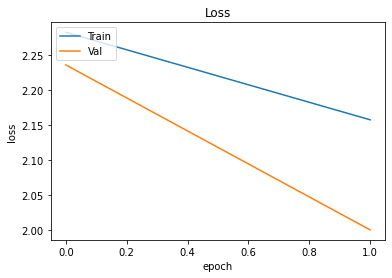

In [40]:
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Train', 'Val'], loc='upper left')

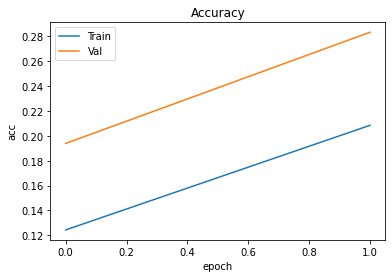

In [41]:
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('Accuracy')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.legend(['Train', 'Val'], loc='upper left')

In [42]:
history3_100 = model3.fit(x_train, y_train, epochs=100, batch_size=128, validation_data=(x_test, y_test))

Epoch 1/100
391/391 [==============================] - 4s 9ms/step - loss: 1.9527 - accuracy: 0.2785 - val_loss: 1.8291 - val_accuracy: 0.3392
Epoch 2/100
391/391 [==============================] - 3s 9ms/step - loss: 1.8476 - accuracy: 0.3125 - val_loss: 1.7457 - val_accuracy: 0.3576
Epoch 3/100
391/391 [==============================] - 3s 9ms/step - loss: 1.7724 - accuracy: 0.3391 - val_loss: 1.7036 - val_accuracy: 0.3773
Epoch 4/100
391/391 [==============================] - 4s 9ms/step - loss: 1.7167 - accuracy: 0.3597 - val_loss: 1.6144 - val_accuracy: 0.4091
Epoch 5/100
391/391 [==============================] - 3s 9ms/step - loss: 1.6554 - accuracy: 0.3852 - val_loss: 1.6233 - val_accuracy: 0.4154
Epoch 6/100
391/391 [==============================] - 4s 9ms/step - loss: 1.6090 - accuracy: 0.4016 - val_loss: 1.5302 - val_accuracy: 0.4480
Epoch 7/100
391/391 [==============================] - 4s 9ms/step - loss: 1.5646 - accuracy: 0.4201 - val_loss: 1.5181 - val_accuracy: 0.4559

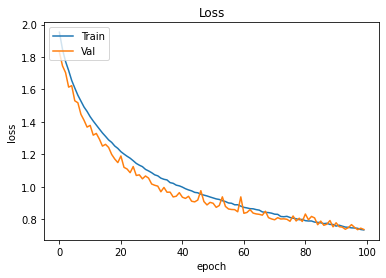

In [43]:
plt.plot(history3_100.history['loss'])
plt.plot(history3_100.history['val_loss'])
plt.title('Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Train', 'Val'], loc='upper left')

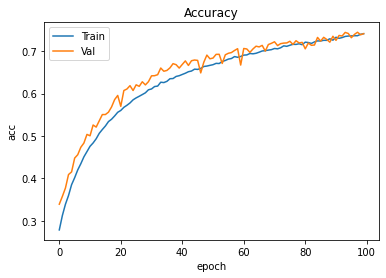

In [44]:
plt.plot(history3_100.history['accuracy'])
plt.plot(history3_100.history['val_accuracy'])
plt.title('Accuracy')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.legend(['Train', 'Val'], loc='upper left')

### Optimization

Keras supports different optimization models to use in model.compile, see https://keras.io/optimizers/.

- Try different parameters for the SGD like initial learning rate and decay.
- Try some of the oder popular optimization functions, like RMSprop, AdaGrad and Adam

